In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from prettytable import PrettyTable
import plotly.express as px
import plotly.graph_objects as go


## Unit Helper

In [316]:
def is_valid_date(date_str):
    try:
        pd.to_datetime(date_str, format='%Y-%m-%d', errors='raise')
        return True
    except ValueError:
        return False

In [164]:
def plot_missing_values_heatmap(df, title=""):
    plt.figure(figsize=(10, 6))
    sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
    plt.title(title)
    plt.show()

In [165]:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

In [268]:
def remove_null_values(df, threshold_ratio=0.5):
    """
    Membersihkan nilai null dari dataframe dengan langkah-langkah berikut:
    1. Menghapus kolom dengan nilai null lebih dari threshold_ratio.
    2. Mengisi nilai null yang tersisa dengan modus (untuk data kategori) atau median (untuk data numerik).
    3. Menghapus baris yang masih memiliki nilai null.

    Parameters:
    df (pd.DataFrame): DataFrame yang akan dibersihkan.
    threshold_ratio (float): Rasio batas untuk menghapus kolom (default 0.5).

    Returns:
    pd.DataFrame: DataFrame yang sudah dibersihkan.
    """
    # Mengidentifikasi kolom dengan terlalu banyak nilai null (lebih dari threshold_ratio)
    threshold = len(df) * threshold_ratio
    df_cleaned = df.dropna(thresh=threshold, axis=1)
    
    # Mengisi nilai null yang tersisa menggunakan metode loc
    for column in df_cleaned.columns:
        if df_cleaned[column].dtype == 'object':
            mode_value = df_cleaned[column].mode()[0]
            df_cleaned.loc[:, column] = df_cleaned[column].fillna(mode_value)
        else:
            median_value = df_cleaned[column].median()
            df_cleaned.loc[:, column] = df_cleaned[column].fillna(median_value)

    # Menangani nilai null pada kolom kategori dengan menggantinya dengan 'Unknown'
    for column in df_cleaned.select_dtypes(include=['object']).columns:
        df_cleaned.loc[:, column] = df_cleaned[column].fillna('Unknown')
        
    # Menghapus baris yang masih memiliki nilai null
    df_cleaned = df_cleaned.dropna()
    
    return df_cleaned

# Load Datasets

In [129]:
cycles = pd.read_csv('./datasets/cycles.csv')
fasting = pd.read_csv('./datasets/fasting.csv')
fastings = pd.read_csv('./datasets/fastings.csv')
feeds = pd.read_csv('./datasets/feeds.csv')
harvests = pd.read_csv('./datasets/harvests.csv')
measurements = pd.read_csv('./datasets/measurements.csv')
mortalities = pd.read_csv('./datasets/mortalities.csv')
samplings = pd.read_csv('./datasets/samplings.csv')

# Data Observation
---
## A. Cycles

In [98]:
df_cyles = cycles[['id', 'started_at', 'finished_at', 'total_seed', 'area', 'pond_id']].copy()

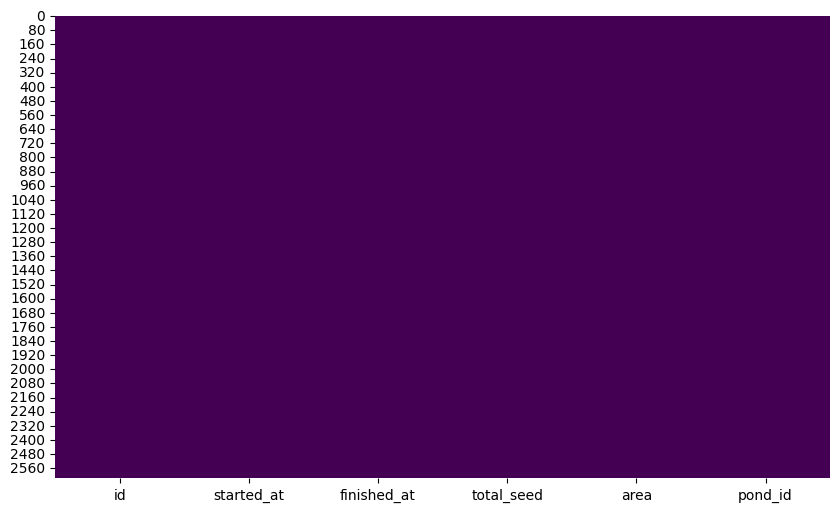

In [99]:
plot_missing_values_heatmap(df_cyles)

In [100]:
df_cyles.head()

,id,started_at,finished_at,total_seed,area,pond_id
0,18876,2022-10-14 00:00:00.000,2023-01-29 00:00:00.000,331920,4030.0,36294
1,22118,2023-04-26 00:00:00.000,2023-06-23 00:00:00.000,40000,399.0,37102
2,24088,2023-08-01 00:00:00.000,2023-10-18 00:00:00.000,357570,2000.0,39154
3,17743,2022-07-19 00:00:00.000,2022-09-29 00:00:00.000,168275,1512.0,20914
4,17125,2022-07-07 00:00:00.000,2022-09-20 00:00:00.000,188000,1225.0,34187


In [101]:
df_cyles['started_at'] = pd.to_datetime(df_cyles['started_at'])
df_cyles['finished_at'] = pd.to_datetime(df_cyles['finished_at'])

In [102]:
df_cyles.insert(
    loc=df_cyles.columns.get_loc('finished_at') + 1,
    column='long_cycle',
    value=(df_cyles['finished_at'] - df_cyles['started_at'])
)

In [103]:
df_cyles.sort_values('id').duplicated().any()

True

In [104]:
df_cyles.drop_duplicates()

,id,started_at,finished_at,long_cycle,total_seed,area,pond_id
0,18876,2022-10-14,2023-01-29,107 days,331920,4030.0,36294
1,22118,2023-04-26,2023-06-23,58 days,40000,399.0,37102
2,24088,2023-08-01,2023-10-18,78 days,357570,2000.0,39154
3,17743,2022-07-19,2022-09-29,72 days,168275,1512.0,20914
4,17125,2022-07-07,2022-09-20,75 days,188000,1225.0,34187
...,...,...,...,...,...,...,...
2612,19131,2022-10-25,2023-01-21,88 days,300000,4999.9,34712
2613,27552,2023-11-05,2024-02-13,100 days,100000,900.0,45697
2614,27885,2023-12-02,2024-02-29,89 days,30716,86.0,24570
2615,15868,2022-04-28,2022-06-21,54 days,150000,1600.0,32398


In [105]:
if df_cyles.duplicated().any():
    df_cyles = df_cyles.drop_duplicates().copy()

In [106]:
df_cyles.duplicated().any()

False

## B. Harvest

In [107]:
harvests.head()

,cycle_id,updated_at,size,created_at,weight,id,harvested_at,status,selling_price
0,15013.0,2022-07-18 08:42:59,399.86,2022-07-18 08:42:59,0.01,11960.0,2022-04-17,Failed,NaN
1,11848.0,2021-10-25 23:29:53,300.00,2021-10-24 08:38:53,46.00,7520.0,2021-10-22,Full,1610000.0
2,11848.0,2021-10-25 23:29:35,300.00,2021-10-25 23:29:35,10.00,7546.0,2021-10-21,Partial,350000.0
3,4666.0,2020-10-08 02:07:18,110.00,2020-10-08 02:07:18,270.50,3009.0,2020-08-31,Failed,NaN
4,4666.0,2020-10-08 02:07:37,190.00,2020-10-08 02:07:37,270.50,3010.0,2020-08-31,Failed,NaN


In [108]:
df_harvests = harvests[['cycle_id', 'harvested_at', 'status', 'size', 'weight']].copy()

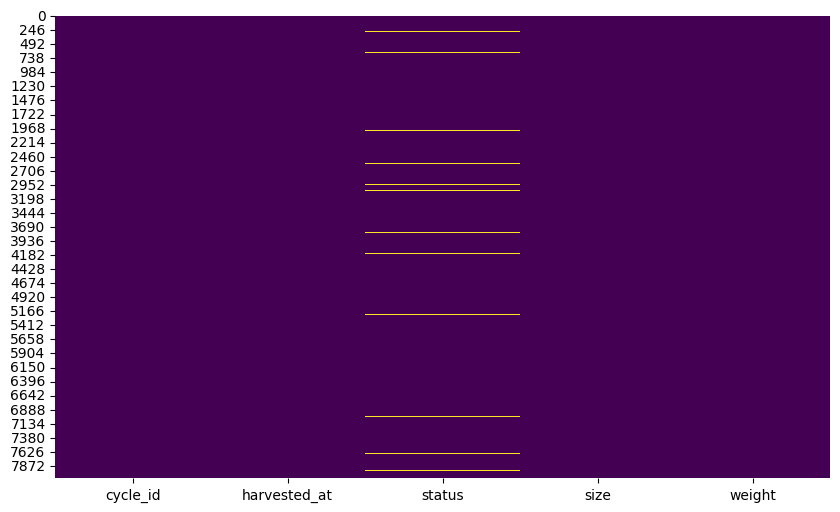

In [109]:
plot_missing_values_heatmap(df_harvests)

In [110]:
df_harvests.isnull().sum()

cycle_id          0
harvested_at      0
status          263
size              0
weight            0
dtype: int64

In [111]:
modus_status = df_harvests['status'].mode()[0]
df_harvests['status'].fillna(modus_status, inplace=True)

/var/folders/zz/htmnld_148b1dbm4wj_hyrq80000gn/T/ipykernel_12108/3139325641.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_harvests['status'].fillna(modus_status, inplace=True)


In [112]:
df_harvests.isnull().sum()

cycle_id        0
harvested_at    0
status          0
size            0
weight          0
dtype: int64

In [113]:
df_harvests.size

40435

In [114]:
df_harvests_cycle = pd.merge(df_cyles, df_harvests, left_on="id", right_on="cycle_id", how='inner').sort_values('cycle_id')

In [115]:
df_harvests_cycle = df_harvests_cycle.sort_values(["cycle_id", "harvested_at"]).copy()

In [116]:
df_harvests_cycle = df_harvests_cycle.drop_duplicates()

In [117]:
df_harvests_cycle.duplicated().any()

False

In [118]:
df_harvests_cycle.head(30)

,id,started_at,finished_at,long_cycle,total_seed,area,pond_id,cycle_id,harvested_at,status,size,weight
5964,3458,2020-03-07,2020-06-27,112 days,566669,4968.0,12969,3458.0,2020-05-13,Partial,94.0,1643.13
5965,3458,2020-03-07,2020-06-27,112 days,566669,4968.0,12969,3458.0,2020-05-26,Partial,71.0,1503.80
5966,3458,2020-03-07,2020-06-27,112 days,566669,4968.0,12969,3458.0,2020-06-13,Partial,49.0,1206.00
5967,3458,2020-03-07,2020-06-27,112 days,566669,4968.0,12969,3458.0,2020-06-27,Full,41.0,3030.00
6978,3459,2020-03-07,2020-07-06,121 days,566669,4968.0,12996,3459.0,2020-05-13,Partial,97.0,1576.46
6979,3459,2020-03-07,2020-07-06,121 days,566669,4968.0,12996,3459.0,2020-05-26,Partial,73.0,1550.00
6980,3459,2020-03-07,2020-07-06,121 days,566669,4968.0,12996,3459.0,2020-06-13,Partial,49.0,1183.40
6981,3459,2020-03-07,2020-07-06,121 days,566669,4968.0,12996,3459.0,2020-07-06,Full,37.0,3144.18
4297,4036,2020-04-11,2020-05-20,39 days,172250,800.0,12685,4036.0,2020-05-17,Partial,350.0,170.00
4296,4036,2020-04-11,2020-05-20,39 days,172250,800.0,12685,4036.0,2020-05-20,Full,350.0,271.00


- Harvests akan dihitung jumlah pemanenan per cycles
- Dari proses ini akan menghasilkan kolom

<code>
['started_at', 'finished_at', 'long_cycles', 'area', 'num_of_harvests', 'avg_size', 'weight']
</code>

In [120]:
df_harvests_cycle.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7921 entries, 5964 to 3952
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype          
---  ------        --------------  -----          
 0   id            7921 non-null   int64          
 1   started_at    7921 non-null   datetime64[ns] 
 2   finished_at   7921 non-null   datetime64[ns] 
 3   long_cycle    7921 non-null   timedelta64[ns]
 4   total_seed    7921 non-null   int64          
 5   area          7921 non-null   float64        
 6   pond_id       7921 non-null   int64          
 7   cycle_id      7921 non-null   float64        
 8   harvested_at  7921 non-null   object         
 9   status        7921 non-null   object         
 10  size          7921 non-null   float64        
 11  weight        7921 non-null   float64        
dtypes: datetime64[ns](2), float64(4), int64(3), object(2), timedelta64[ns](1)
memory usage: 804.5+ KB


In [121]:
df_harvests_cycle

,id,started_at,finished_at,long_cycle,total_seed,area,pond_id,cycle_id,harvested_at,status,size,weight
5964,3458,2020-03-07,2020-06-27,112 days,566669,4968.0,12969,3458.0,2020-05-13,Partial,94.0,1643.13
5965,3458,2020-03-07,2020-06-27,112 days,566669,4968.0,12969,3458.0,2020-05-26,Partial,71.0,1503.80
5966,3458,2020-03-07,2020-06-27,112 days,566669,4968.0,12969,3458.0,2020-06-13,Partial,49.0,1206.00
5967,3458,2020-03-07,2020-06-27,112 days,566669,4968.0,12969,3458.0,2020-06-27,Full,41.0,3030.00
6978,3459,2020-03-07,2020-07-06,121 days,566669,4968.0,12996,3459.0,2020-05-13,Partial,97.0,1576.46
...,...,...,...,...,...,...,...,...,...,...,...,...
1333,29659,2024-02-11,2024-03-14,32 days,75000,2183.0,45493,29659.0,2024-03-14,Full,200.0,60.00
7558,29679,2024-02-15,2024-03-28,42 days,26671,78.5,18522,29679.0,2024-03-12,Partial,61.4,127.00
7559,29679,2024-02-15,2024-03-28,42 days,26671,78.5,18522,29679.0,2024-03-28,Full,50.6,241.00
6376,29873,2024-01-09,2024-03-25,76 days,125000,900.0,43651,29873.0,2024-03-25,Full,85.0,1038.00


In [122]:
df_harvests_cycle.groupby('cycle_id').size().reset_index(name='num_of_harvest')

,cycle_id,num_of_harvest
0,3458.0,4
1,3459.0,4
2,4036.0,2
3,4038.0,6
4,4039.0,5
...,...,...
2485,29619.0,2
2486,29659.0,1
2487,29679.0,2
2488,29873.0,1


## C. Fastings

In [190]:
df_fastings = pd.concat([fasting, fastings])

In [191]:
df_fastings

,logged_date,cycle_id,fasting
0,2022-10-17,15804.0,1.0
1,2022-11-27,15804.0,0.0
2,2022-11-28,15804.0,0.0
3,2022-11-29,15804.0,0.0
4,2022-12-01,15804.0,1.0
...,...,...,...
32374,2024-01-02,28500.0,1.0
32375,2024-01-02,28500.0,0.0
32376,2023-08-07,24650.0,1.0
32377,2023-09-06,24650.0,1.0


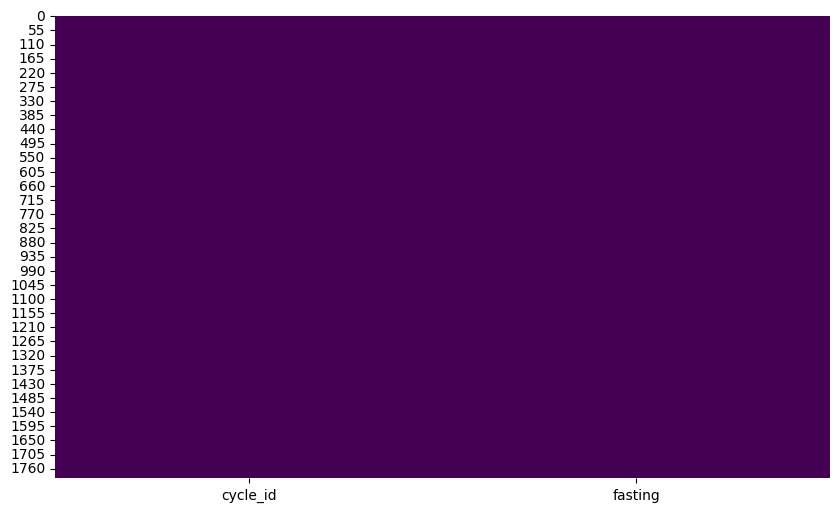

In [211]:
plot_missing_values_heatmap(df_fastings)

In [212]:
df_fastings.duplicated().any()

False

In [198]:
df_fastings = df_fastings.groupby('cycle_id')['fasting'].any().reset_index()

In [209]:
df_fastings.fasting.value_counts('fasting')

fasting
True     0.832499
False    0.167501
Name: proportion, dtype: float64

In [210]:
df_fastings.size

3594

## D. Measurements

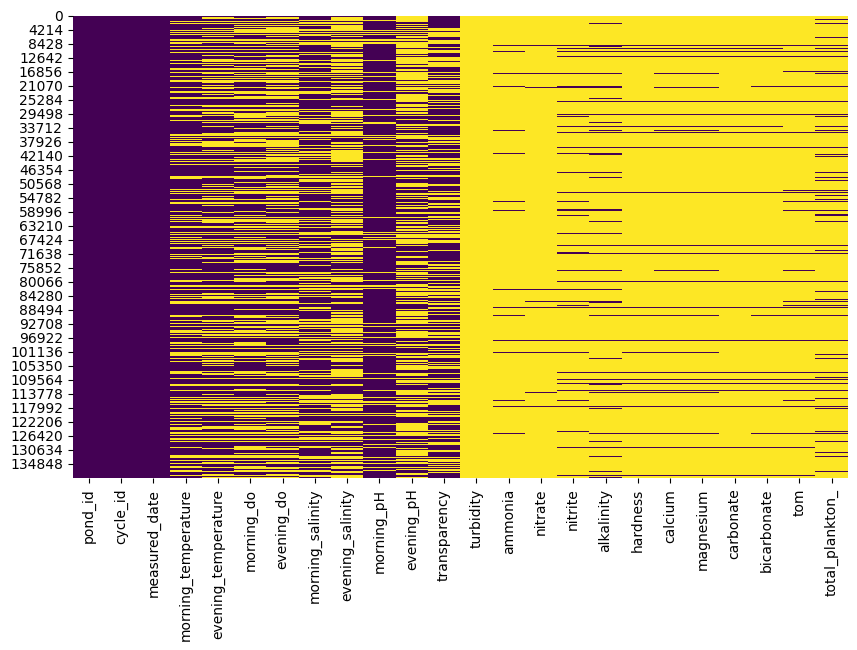

In [124]:
plot_missing_values_heatmap(measurements)

In [137]:
# Mengidentifikasi kolom dengan terlalu banyak nilai null (lebih dari 50%)
threshold = len(measurements) * 0.5
df_measurements = measurements.copy()
df_measurements = measurements.dropna(thresh=threshold, axis=1)

# Mengisi nilai null yang tersisa menggunakan metode loc
for column in df_measurements.columns:
    if df_measurements[column].dtype == 'object':
        mode_value = df_measurements[column].mode()[0]
        df_measurements.loc[:, column] = df_measurements[column].fillna(mode_value)
    else:
        median_value = df_measurements[column].median()
        df_measurements.loc[:, column] = df_measurements[column].fillna(median_value)

# Menghapus baris yang masih memiliki nilai null
df_measurements = df_measurements.dropna()

In [143]:
df_measurements.sort_values(["cycle_id", "measured_date"]).head(40)

,pond_id,cycle_id,measured_date,morning_temperature,evening_temperature,morning_do,evening_do,morning_salinity,morning_pH,transparency
67350,12969,3458,2020-05-03,28.0,30.0,4.97,5.64,23.0,7.9,38.0
85599,12969,3458,2020-05-04,28.0,30.0,4.97,5.64,23.0,7.9,38.0
38319,12969,3458,2020-05-05,28.0,30.0,4.97,5.64,23.0,7.9,38.0
15629,12969,3458,2020-05-06,28.0,30.0,4.97,5.64,23.0,7.9,38.0
63804,12969,3458,2020-05-07,28.0,30.0,4.97,5.64,23.0,7.9,38.0
76367,12969,3458,2020-05-08,28.0,30.0,4.97,5.64,23.0,7.9,38.0
120977,12969,3458,2020-05-10,28.0,30.0,4.97,5.64,23.0,7.9,38.0
17677,12969,3458,2020-05-11,28.0,30.0,4.97,5.64,23.0,7.9,38.0
74919,12969,3458,2020-05-12,28.0,30.0,4.97,5.64,23.0,7.9,38.0
47836,12969,3458,2020-05-13,28.0,30.0,4.97,5.64,23.0,7.9,38.0


In [148]:
df_measurements["measured_date"] = pd.to_datetime(df_measurements['measured_date'])

In [150]:
df_measurements.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139050 entries, 0 to 139049
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   pond_id              139050 non-null  int64         
 1   cycle_id             139050 non-null  int64         
 2   measured_date        139050 non-null  datetime64[ns]
 3   morning_temperature  139050 non-null  float64       
 4   evening_temperature  139050 non-null  float64       
 5   morning_do           139050 non-null  float64       
 6   evening_do           139050 non-null  float64       
 7   morning_salinity     139050 non-null  float64       
 8   morning_pH           139050 non-null  float64       
 9   transparency         139050 non-null  float64       
dtypes: datetime64[ns](1), float64(7), int64(2)
memory usage: 10.6 MB


In [153]:
df_measurement_group = df_measurements.groupby("cycle_id").mean().reset_index()

<Axes: >

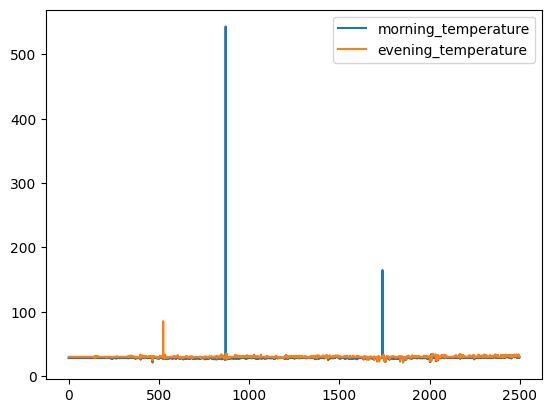

In [163]:
df_measurement_group[["morning_temperature", "evening_temperature"]].plot()

In [167]:
df_measurement_group = remove_outliers(df_measurement_group, df_measurement_group.columns)

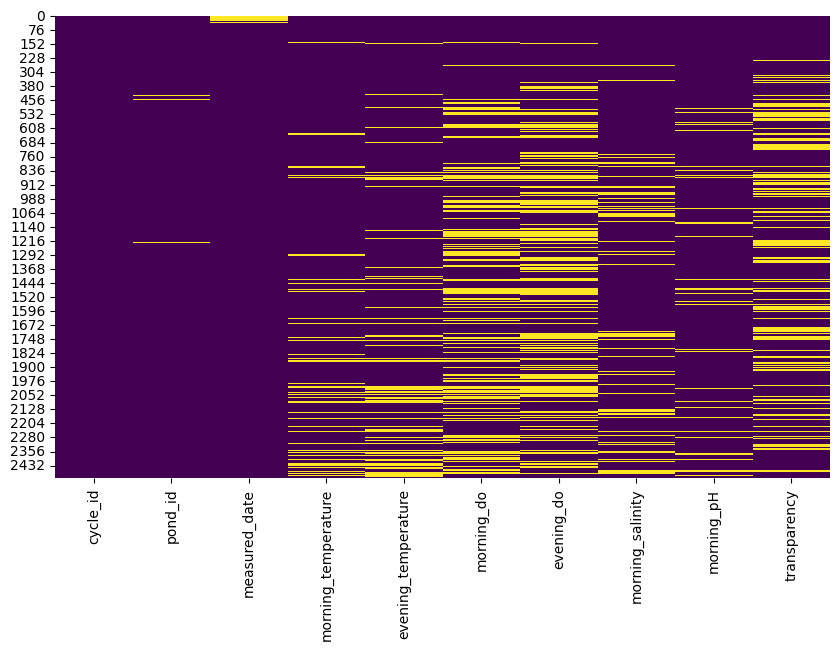

In [171]:
plot_missing_values_heatmap(df_measurement_group)

In [173]:
df_measurement_group=remove_null_values(df_measurement_group)

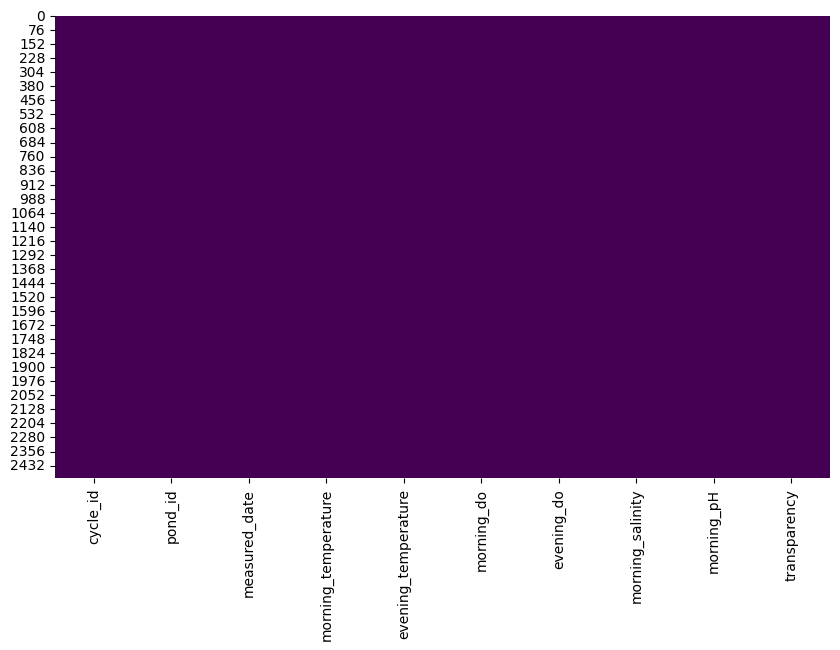

In [175]:
plot_missing_values_heatmap(df_measurement_group)

<Axes: >

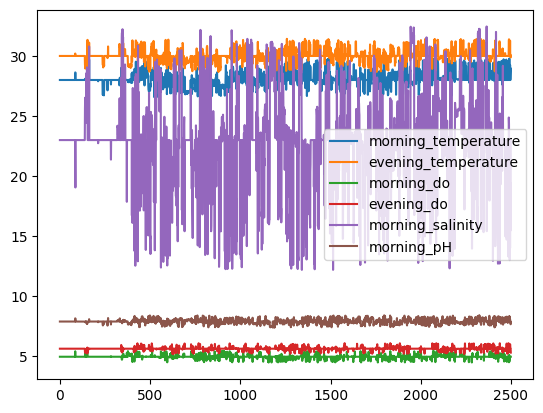

In [179]:
df_measurement_group[["morning_temperature", "evening_temperature", "morning_do", "evening_do", "morning_salinity", "morning_pH"]].plot()

In [181]:
df_measurement_group[["morning_temperature", "evening_temperature", "morning_do", "evening_do", "morning_salinity", "morning_pH"]].corr()

,morning_temperature,evening_temperature,morning_do,evening_do,morning_salinity,morning_pH
morning_temperature,1.000000,0.499977,-0.036565,0.098002,-0.026291,-0.062474
evening_temperature,0.499977,1.000000,-0.049320,0.114630,-0.089625,0.043995
morning_do,-0.036565,-0.049320,1.000000,0.058023,0.008242,-0.053904
evening_do,0.098002,0.114630,0.058023,1.000000,-0.045026,0.027439
morning_salinity,-0.026291,-0.089625,0.008242,-0.045026,1.000000,-0.136078
morning_pH,-0.062474,0.043995,-0.053904,0.027439,-0.136078,1.000000


## E. Samplings

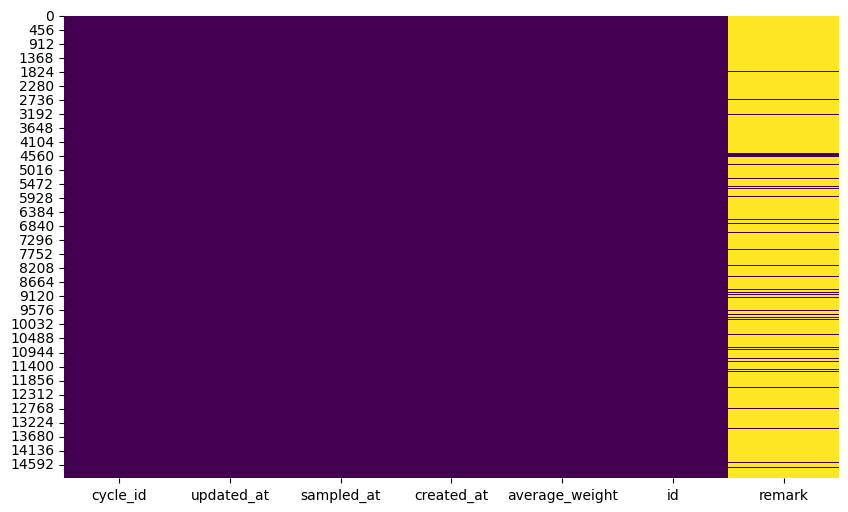

In [295]:
plot_missing_values_heatmap(samplings)

In [299]:
df_samplings = samplings.drop(['updated_at', 'created_at', 'remark', 'id'], axis=1)

In [313]:
df_samplings = df_samplings.sort_values(['cycle_id', 'sampled_at'])

In [315]:
df_samplings.sort_values('sampled_at')

,cycle_id,sampled_at,average_weight
12678,25134.0,1-01-01,5.72
13351,18760.0,2020-01-26,8.86
8745,3458.0,2020-04-10,4.37
3617,3459.0,2020-04-10,4.18
8746,3458.0,2020-04-17,5.23
...,...,...,...
9771,28792.0,2024-03-30,9.34
10861,29518.0,2024-03-30,7.14
14591,29619.0,2024-04-01,6.66
3213,28791.0,2024-04-02,7.40


In [320]:
# Terapkan fungsi ke kolom tanggal dan filter data yang valid
df_samplings['is_valid_date'] = df_samplings['sampled_at'].apply(is_valid_date)
df_samplings = df_samplings[df_samplings['is_valid_date']].drop(columns=['is_valid_date'])


In [323]:
df_samplings['sampled_at'] = pd.to_datetime(df_samplings['sampled_at'])

In [324]:
df_samplings.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15031 entries, 8745 to 5774
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   cycle_id        15031 non-null  float64       
 1   sampled_at      15031 non-null  datetime64[ns]
 2   average_weight  15031 non-null  float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 469.7 KB


# Data Merging

## Merged on Harvesting

In [214]:
df_harvests_cycle.head()

,id,started_at,finished_at,long_cycle,total_seed,area,pond_id,cycle_id,harvested_at,status,size,weight
5964,3458,2020-03-07,2020-06-27,112 days,566669,4968.0,12969,3458.0,2020-05-13,Partial,94.0,1643.13
5965,3458,2020-03-07,2020-06-27,112 days,566669,4968.0,12969,3458.0,2020-05-26,Partial,71.0,1503.80
5966,3458,2020-03-07,2020-06-27,112 days,566669,4968.0,12969,3458.0,2020-06-13,Partial,49.0,1206.00
5967,3458,2020-03-07,2020-06-27,112 days,566669,4968.0,12969,3458.0,2020-06-27,Full,41.0,3030.00
6978,3459,2020-03-07,2020-07-06,121 days,566669,4968.0,12996,3459.0,2020-05-13,Partial,97.0,1576.46


In [217]:
df_harvests_cycle.groupby('cycle_id').size().reset_index(name='num_of_harvest')

,cycle_id,num_of_harvest
0,3458.0,4
1,3459.0,4
2,4036.0,2
3,4038.0,6
4,4039.0,5
...,...,...
2485,29619.0,2
2486,29659.0,1
2487,29679.0,2
2488,29873.0,1


In [275]:
# Menghitung jumlah panen (num_of_harvest) per cycle_id
num_of_harvest = df_harvests_cycle.groupby('cycle_id').size().reset_index(name='num_of_harvest')

# Menghitung rata-rata dari setiap kolom berdasarkan cycle_id
average_df = df_harvests_cycle[["long_cycle", "total_seed", "area", "cycle_id", "size", "weight"]].groupby('cycle_id').mean().reset_index()

# Menggabungkan hasil penghitungan jumlah panen dengan rata-rata dari setiap kolom
df_merged = pd.merge(average_df, num_of_harvest, on='cycle_id')

In [276]:
df_merged.head(10)

,cycle_id,long_cycle,total_seed,area,size,weight,num_of_harvest
0,3458.0,112 days,566669.0,4968.0,63.750000,1845.732500,4
1,3459.0,121 days,566669.0,4968.0,64.000000,1863.510000,4
2,4036.0,39 days,172250.0,800.0,350.000000,220.500000,2
3,4038.0,94 days,350000.0,2700.0,89.000000,1086.976667,6
4,4039.0,94 days,210000.0,1030.0,109.200000,590.508000,5
5,4044.0,119 days,215858.0,1250.0,70.857143,506.297143,7
6,4045.0,119 days,227526.0,1310.0,63.800000,378.138000,10
7,4046.0,115 days,180854.0,1040.0,63.750000,783.030000,4
8,4047.0,108 days,233360.0,1340.0,72.833333,644.813333,6
9,4048.0,119 days,265447.0,1540.0,66.700000,436.421000,10


## Merged on measurements

In [277]:
df_merged = pd.merge(df_measurement_group, df_merged, on=["cycle_id", "cycle_id"], how="outer")

In [278]:
df_merged

,cycle_id,pond_id,measured_date,morning_temperature,evening_temperature,morning_do,evening_do,morning_salinity,morning_pH,transparency,long_cycle,total_seed,area,size,weight,num_of_harvest
0,3458,12969.0,2023-01-09 12:25:06.976744192,28.000000,30.000000,4.97,5.640000,23.000000,7.900000,38.0,112 days,566669.0,4968.0,63.75,1845.732500,4.0
1,3459,12996.0,2023-01-09 12:25:06.976744192,28.000000,30.000000,4.97,5.640000,23.000000,7.900000,38.0,121 days,566669.0,4968.0,64.00,1863.510000,4.0
2,4036,12685.0,2023-01-09 12:25:06.976744192,28.000000,30.000000,4.97,5.640000,23.000000,7.900000,38.0,39 days,172250.0,800.0,350.00,220.500000,2.0
3,4038,14334.0,2023-01-09 12:25:06.976744192,28.000000,30.000000,4.97,5.640000,23.000000,7.900000,38.0,94 days,350000.0,2700.0,89.00,1086.976667,6.0
4,4039,14335.0,2023-01-09 12:25:06.976744192,28.000000,30.000000,4.97,5.640000,23.000000,7.900000,38.0,94 days,210000.0,1030.0,109.20,590.508000,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,29619,12688.0,2024-03-06 12:23:13.548387072,29.250419,31.276903,4.97,6.013226,14.018129,8.083645,38.0,49 days,70000.0,216.0,182.50,425.000000,2.0
2496,29659,45493.0,2024-03-04 03:25:42.857142784,28.000000,30.000000,4.97,5.760714,23.000000,7.900000,38.0,32 days,75000.0,2183.0,200.00,60.000000,1.0
2497,29679,18522.0,2024-02-29 12:00:00.000000000,28.000000,30.000000,4.97,5.640000,23.000000,7.900000,38.0,42 days,26671.0,78.5,56.00,184.000000,2.0
2498,29873,43651.0,2024-03-04 04:00:00.000000000,28.591667,29.875000,4.97,5.640000,15.475000,7.674167,38.0,76 days,125000.0,900.0,85.00,1038.000000,1.0


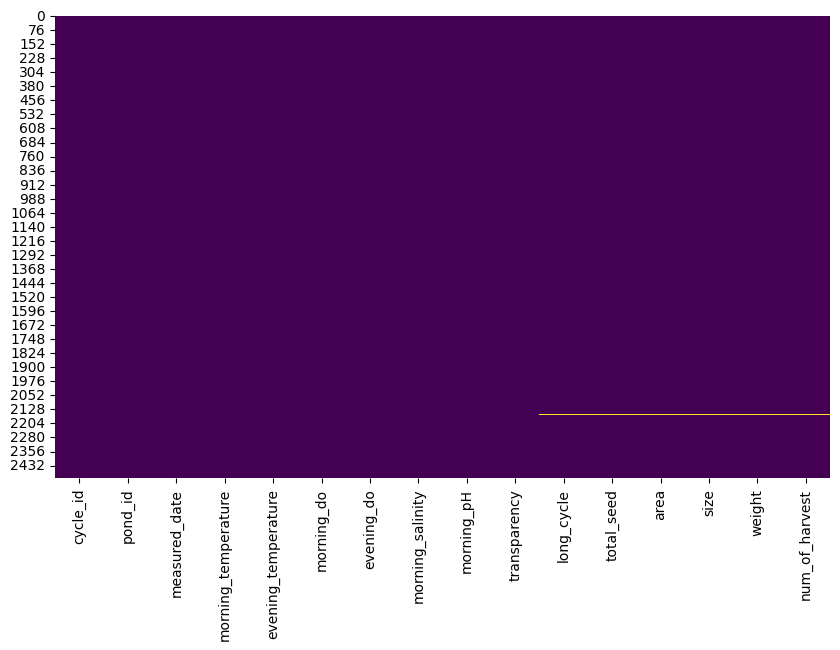

In [279]:
plot_missing_values_heatmap(df_merged)

In [280]:
df_merged = remove_null_values(df_merged)

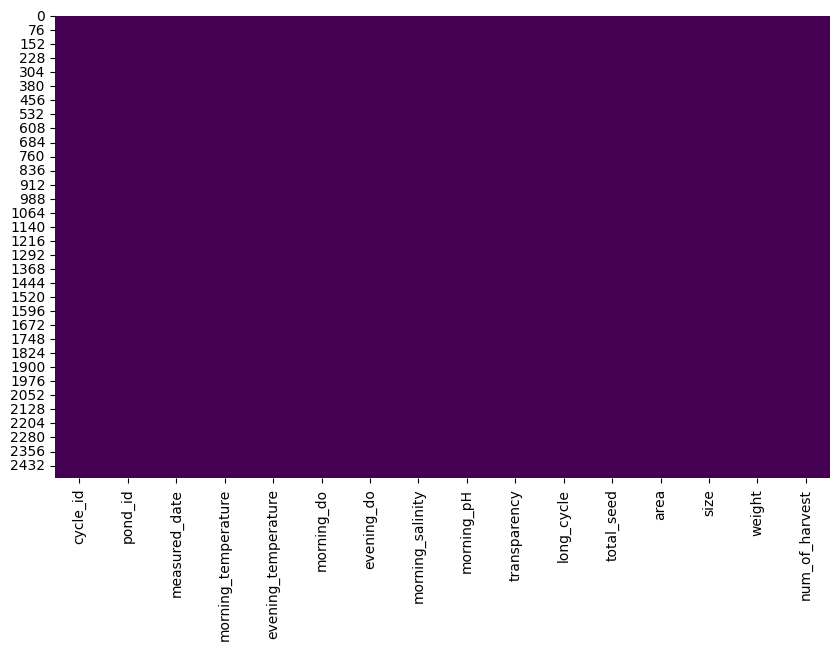

In [281]:
plot_missing_values_heatmap(df_merged)

## Merged on Fasting

In [282]:
df_merged = pd.merge(df_fastings, df_merged, on="cycle_id", how='outer')

In [283]:
df_merged = remove_null_values(df_merged)

/var/folders/zz/htmnld_148b1dbm4wj_hyrq80000gn/T/ipykernel_12108/588308657.py:23: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_cleaned.loc[:, column] = df_cleaned[column].fillna(mode_value)
/var/folders/zz/htmnld_148b1dbm4wj_hyrq80000gn/T/ipykernel_12108/588308657.py:30: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_cleaned.loc[:, column] = df_cleaned[column].fillna('Unknown')


In [291]:
df_merged["long_cycle"] = df_merged.long_cycle.dt.days

In [293]:
df_merged.to_csv("./feature_store/merged.csv")

In [294]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2504 entries, 0 to 2503
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   cycle_id             2504 non-null   float64       
 1   fasting              2504 non-null   object        
 2   pond_id              2504 non-null   float64       
 3   measured_date        2504 non-null   datetime64[ns]
 4   morning_temperature  2504 non-null   float64       
 5   evening_temperature  2504 non-null   float64       
 6   morning_do           2504 non-null   float64       
 7   evening_do           2504 non-null   float64       
 8   morning_salinity     2504 non-null   float64       
 9   morning_pH           2504 non-null   float64       
 10  transparency         2504 non-null   float64       
 11  long_cycle           2504 non-null   int64         
 12  total_seed           2504 non-null   float64       
 13  area                 2504 non-nul

## Merge on Samplings

In [331]:
df_samplings.sort_values(['cycle_id', 'sampled_at'])

,cycle_id,sampled_at,average_weight
8745,3458.0,2020-04-10,4.37
8746,3458.0,2020-04-17,5.23
8744,3458.0,2020-04-24,6.69
8743,3458.0,2020-05-01,8.21
8747,3458.0,2020-05-08,9.68
...,...,...,...
5770,29874.0,2024-02-20,4.10
5771,29874.0,2024-02-27,6.20
5772,29874.0,2024-03-05,8.39
5773,29874.0,2024-03-12,8.98


In [359]:
# Fungsi untuk menghitung ADG per siklus
def calculate_adg(group):
    group = group.sort_values(by='sampled_at')
    group['prev_weight'] = group['average_weight'].shift(1)
    group['prev_date'] = group['sampled_at'].shift(1)
    group = group.dropna()  # Drop baris yang memiliki nilai NaN akibat shift
    group['weight_diff'] = group['average_weight'] - group['prev_weight']
    group['days_diff'] = (group['sampled_at'] - group['prev_date']).dt.days
    group['ADG'] = group['weight_diff'] / group['days_diff']
    return group

# Terapkan fungsi ke setiap kelompok cycle_id
df_sampling_adg = df_samplings.groupby('cycle_id').apply(calculate_adg).reset_index(drop=True)

/var/folders/zz/htmnld_148b1dbm4wj_hyrq80000gn/T/ipykernel_12108/451733620.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampling_adg = df_samplings.groupby('cycle_id').apply(calculate_adg).reset_index(drop=True)


In [360]:
df_sampling_adg

,cycle_id,sampled_at,average_weight,prev_weight,prev_date,weight_diff,days_diff,ADG
0,3458.0,2020-04-17,5.23,4.37,2020-04-10,0.86,7,0.122857
1,3458.0,2020-04-24,6.69,5.23,2020-04-17,1.46,7,0.208571
2,3458.0,2020-05-01,8.21,6.69,2020-04-24,1.52,7,0.217143
3,3458.0,2020-05-08,9.68,8.21,2020-05-01,1.47,7,0.210000
4,3458.0,2020-05-15,11.59,9.68,2020-05-08,1.91,7,0.272857
...,...,...,...,...,...,...,...,...
12719,29874.0,2024-02-20,4.10,2.97,2024-02-13,1.13,7,0.161429
12720,29874.0,2024-02-27,6.20,4.10,2024-02-20,2.10,7,0.300000
12721,29874.0,2024-03-05,8.39,6.20,2024-02-27,2.19,7,0.312857
12722,29874.0,2024-03-12,8.98,8.39,2024-03-05,0.59,7,0.084286


In [361]:
df_sampling_adg = df_samping_adg.groupby('cycle_id').agg(
    start_weight=('average_weight', 'first'),
    last_weight=('average_weight', 'last'),
    average_weight=('average_weight', 'mean'),
    average_adg=('ADG', 'mean')
).reset_index()


In [362]:
df_sampling_adg

,cycle_id,start_weight,last_weight,average_weight,average_adg
0,3458.0,5.23,25.18,14.428182,0.270260
1,3459.0,4.95,26.59,15.167500,0.266786
2,4038.0,5.25,16.25,10.725000,0.281250
3,4039.0,5.40,15.70,11.034615,0.273077
4,4044.0,2.77,24.76,13.033077,0.256103
...,...,...,...,...,...
1905,29579.0,4.50,5.30,5.266667,-0.225000
1906,29619.0,6.66,6.66,6.660000,0.186364
1907,29679.0,26.00,20.00,20.792500,0.196429
1908,29873.0,4.32,11.70,7.884000,0.257143


In [366]:
df_merged = pd.merge(df_sampling_adg, df_merged, on="cycle_id", how='inner')

In [367]:
df_merged = remove_null_values(df_merged)

/var/folders/zz/htmnld_148b1dbm4wj_hyrq80000gn/T/ipykernel_12108/588308657.py:23: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_cleaned.loc[:, column] = df_cleaned[column].fillna(mode_value)
/var/folders/zz/htmnld_148b1dbm4wj_hyrq80000gn/T/ipykernel_12108/588308657.py:30: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_cleaned.loc[:, column] = df_cleaned[column].fillna('Unknown')


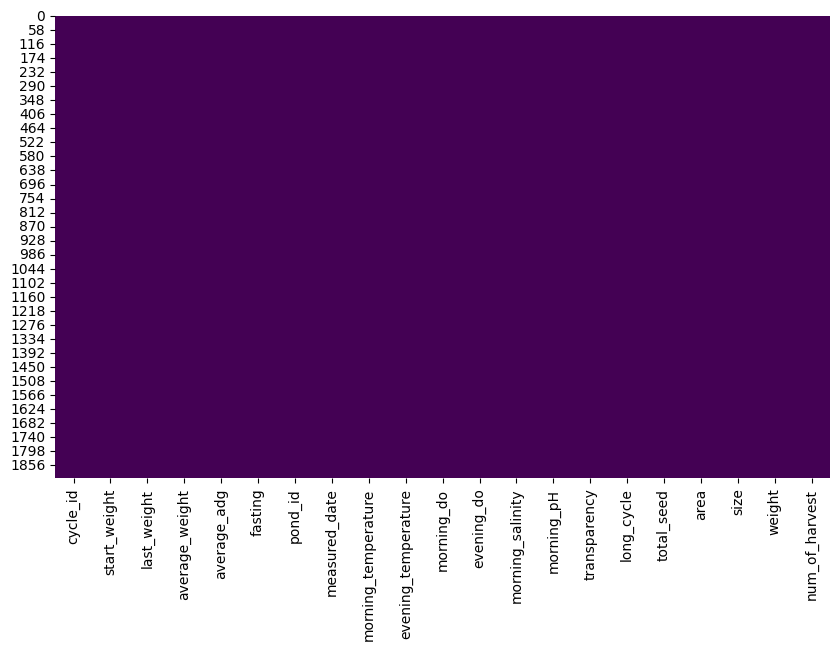

In [368]:
plot_missing_values_heatmap(df_merged)

In [369]:
df_merged.to_csv('./feature_store/merged.csv')